In [8]:
#Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to C:\Users\Jasper
[nltk_data]     Shen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')

In [10]:
df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)
train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)
test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [11]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))
print("\n")
print(train.head())
print("\n")
print(train.info())

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


   UserName  ScreenName   Location     TweetAt                                      OriginalTweet           Sentiment
0      3799       48751     London  16-03-2020  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      3800       48752         UK  16-03-2020  advice Talk to your neighbours family to excha...            Positive
2      3801       48753  Vagabonds  16-03-2020  Coronavirus Australia: Woolworths to give elde...            Positive
3      3802       48754        NaN  16-03-2020  My food stock is not the only one which is emp...            Positive
4      3803       48755        NaN  16-03-2020  Me, ready to go at supermarket during the #COV...  Extremely Negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  -----

缺失值

In [12]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)

Null Values in each column:
      column name  Total missing  Percent missing
0       Location           9424         0.209632
1       UserName              0         0.000000
2     ScreenName              0         0.000000
3        TweetAt              0         0.000000
4  OriginalTweet              0         0.000000
5      Sentiment              0         0.000000


In [13]:
# 比例分析

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)
# Data has 5 classes, let's convert them to 3
def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)
    

sentiment
positive    0.435814
negative    0.378846
neutral     0.185341
Name: proportion, dtype: float64

## 可视化

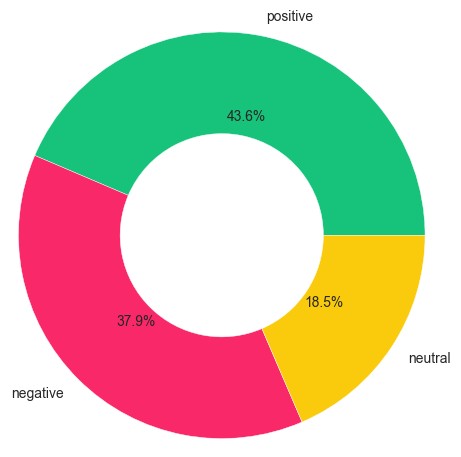

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': ['#17C37B', '#F92969', '#FACA0C']},
              'name': 'train',
              'type': 'bar',
              'x': array(['positive', 'negative', 'neutral'], dtype=object),
              'xaxis': 'x',
              'y': array([18046, 15398,  7713], dtype=int64),
              'yaxis': 'y'},
             {'marker': {'color': ['#17C37B', '#F92969', '#FACA0C']},
              'name': 'test',
              'type': 'bar',
              'x': array(['negative', 'positive', 'neutral'], dtype=object),
              'xaxis': 'x2',
              'y': array([1633, 1546,  619], dtype=int64),
              'yaxis': 'y2'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Train set',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Test set',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 0.45]},
               'xaxis2': {'anchor': 'y2', 'domain': [0.55, 1.0]},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0]},
               'yaxis2': {'anchor': 'x2', 'domain': [0.0, 1.0]}}
})

In [17]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()

fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)



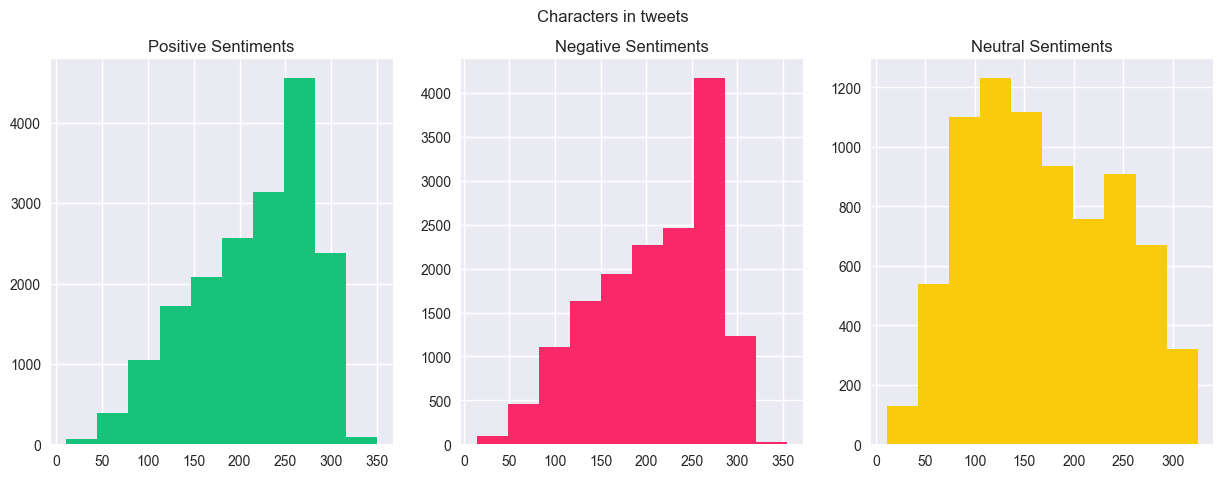

In [18]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

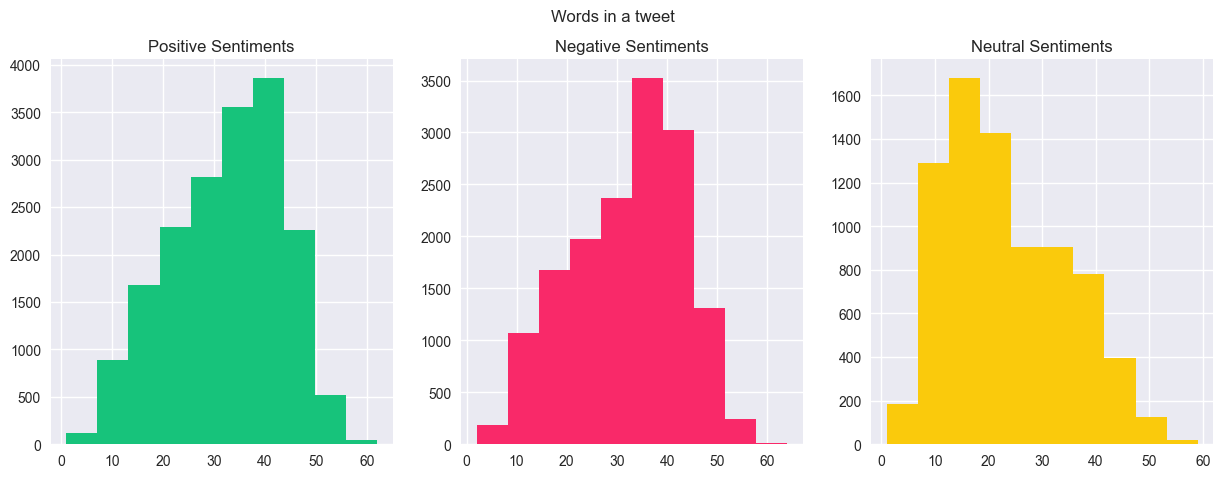

In [19]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

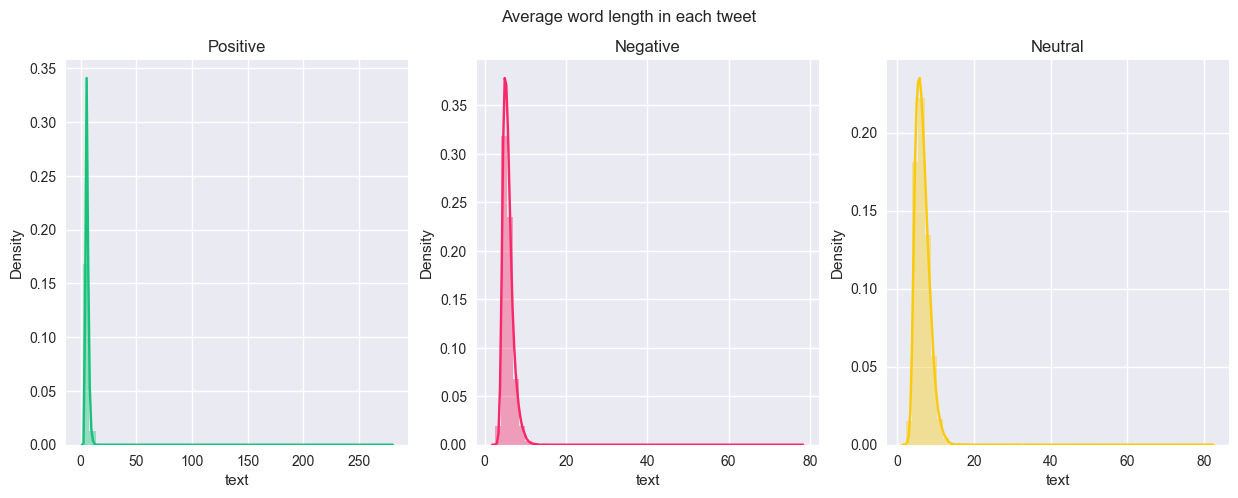

In [20]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=train[train['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=train[train['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')

In [26]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus
np.array(stop)


array({"wasn't", 'being', "it's", 'this', 'ourselves', 'shan', 'he', 'while', 'my', "she's", "you're", "doesn't", 'i', 'once', 'his', 'who', 'has', 'after', "shan't", 'off', 'be', 'as', 'she', 'which', 'can', 'in', "should've", 'until', 'down', 'our', 'why', 'than', 'myself', 'its', 'then', 'during', 'an', 'ain', 'over', 'aren', 'to', 'hers', 'their', 'few', 'through', 'shouldn', 'itself', 'too', "mightn't", 'nor', 'been', 're', "weren't", 'you', 'when', 'doesn', 've', 'ours', 'for', 'herself', 'or', 'above', 'm', 'on', 'her', 'that', "don't", 'same', 'won', 'at', 'd', 'theirs', 'we', 'are', 'was', 'no', 'me', 'have', 'of', 'they', 'only', "haven't", "you'd", 'further', 's', "couldn't", 'himself', 'each', 'below', 'does', 'your', 'do', 'both', 'because', 'is', 'did', 'wouldn', 'against', 'should', 'under', 'yours', 'couldn', "won't", 'yourself', 'having', 'again', "hadn't", 'before', 'all', 'but', 'yourselves', 'it', 'any', 'up', 'them', 'haven', 'a', 'the', 'those', 'about', 'how', 'w

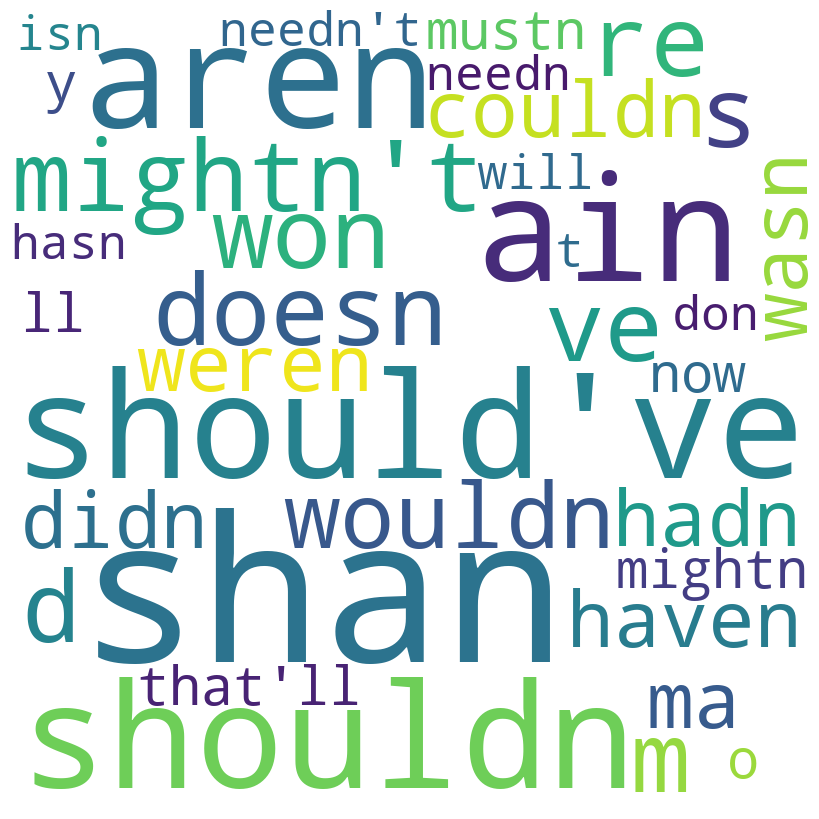

In [23]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)                     
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

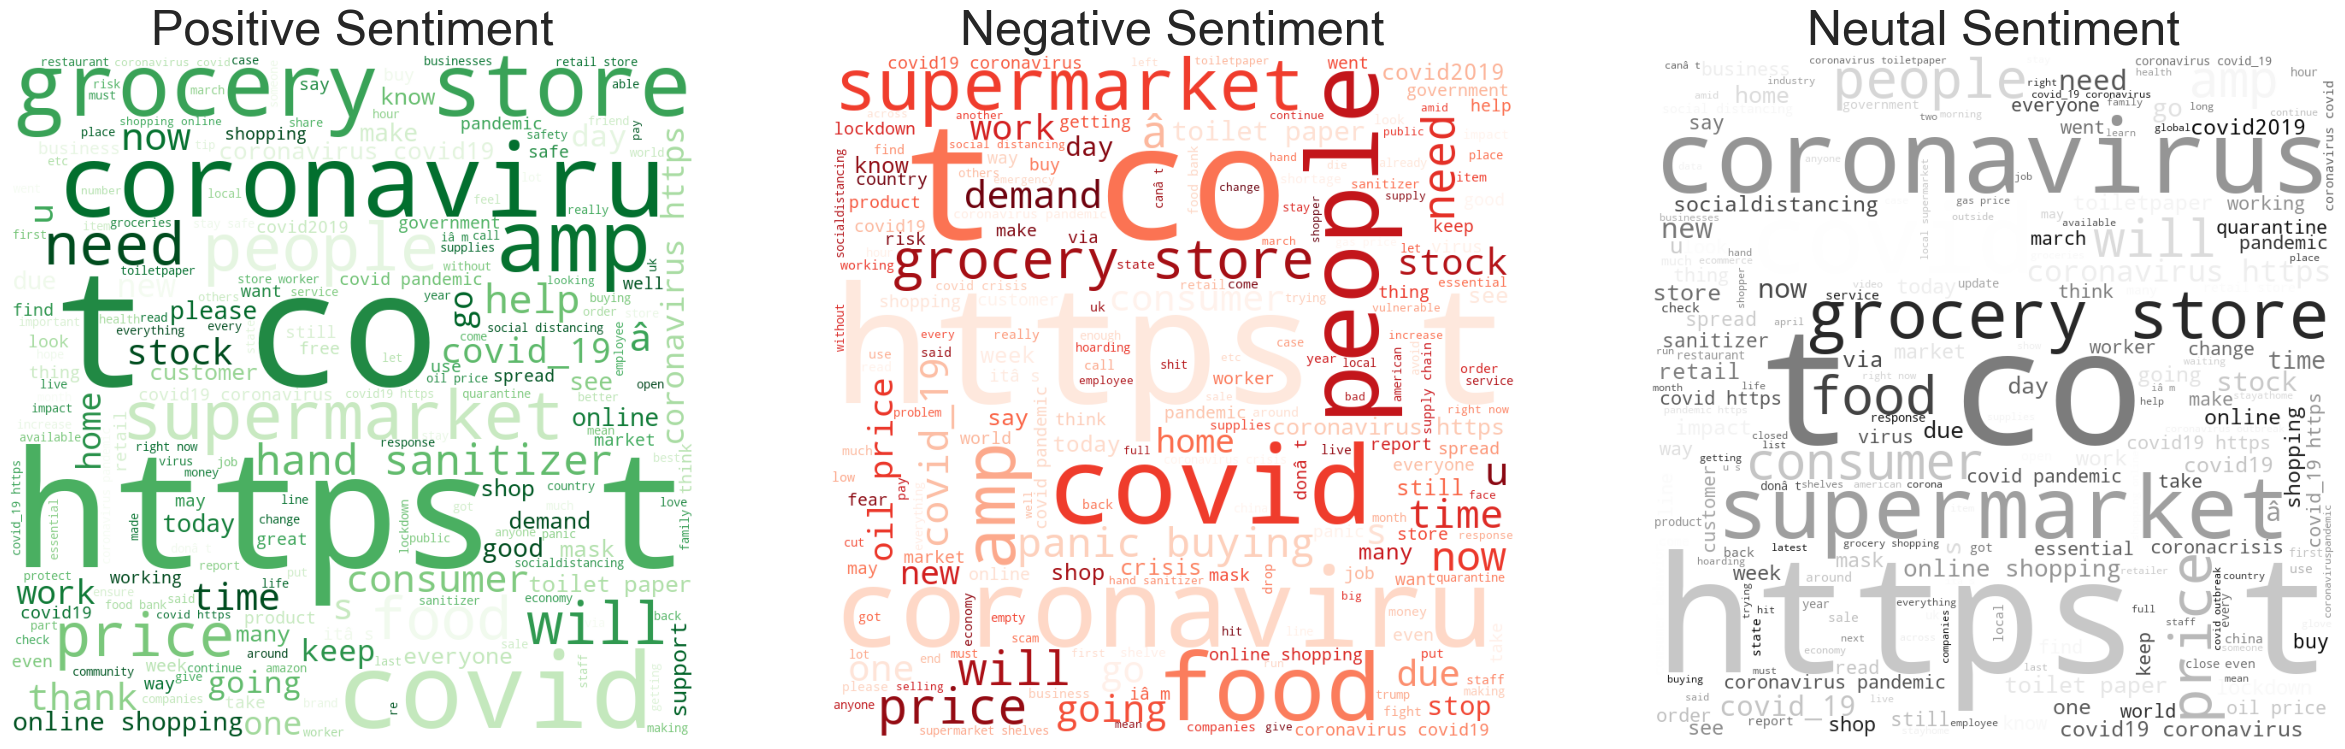

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["sentiment"]=="positive"]
df_neg = df[df["sentiment"]=="negative"]
df_neu = df[df["sentiment"]=="neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);
comment_words = ''
for val in df_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);
comment_words = ''
for val in df_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

### HashTag

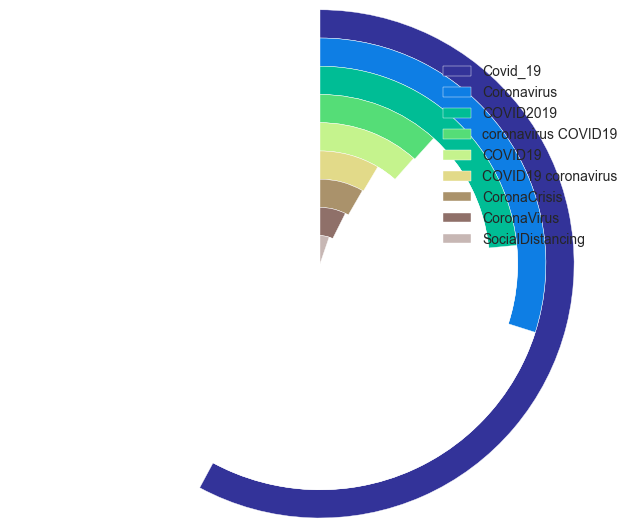

In [29]:
from matplotlib import cm
from math import log10

labels = df['hash'].value_counts()[:][2:11].index.tolist()
data = df['hash'].value_counts()[:][2:11]
df['hash'].value_counts()[:][1:11].index.tolist()
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 
colors = [cm.terrain(i / n) for i in range(n)]
fig, ax = plt.subplots()
ax.axis("equal")
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

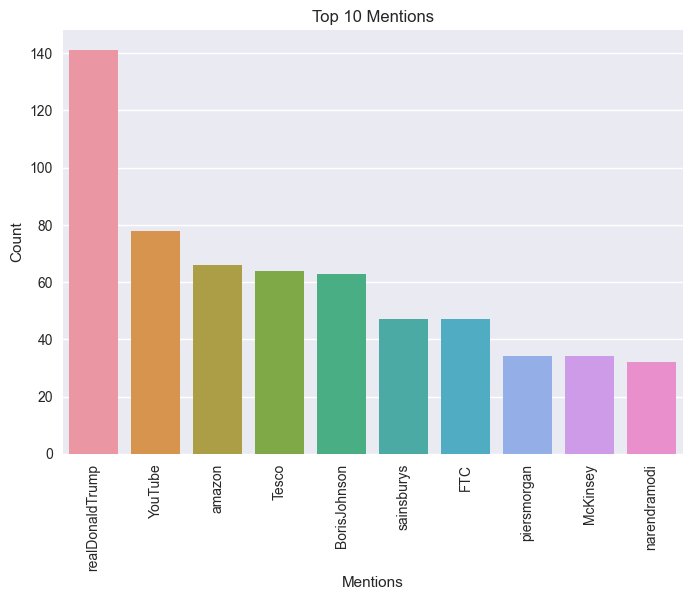

In [48]:

def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp.head()

sns.barplot(x=temp.index, y=temp.values)
plt.xlabel('Mentions')
plt.ylabel('Count')
plt.title('Top 10 Mentions')
plt.xticks(rotation=90)
plt.show()


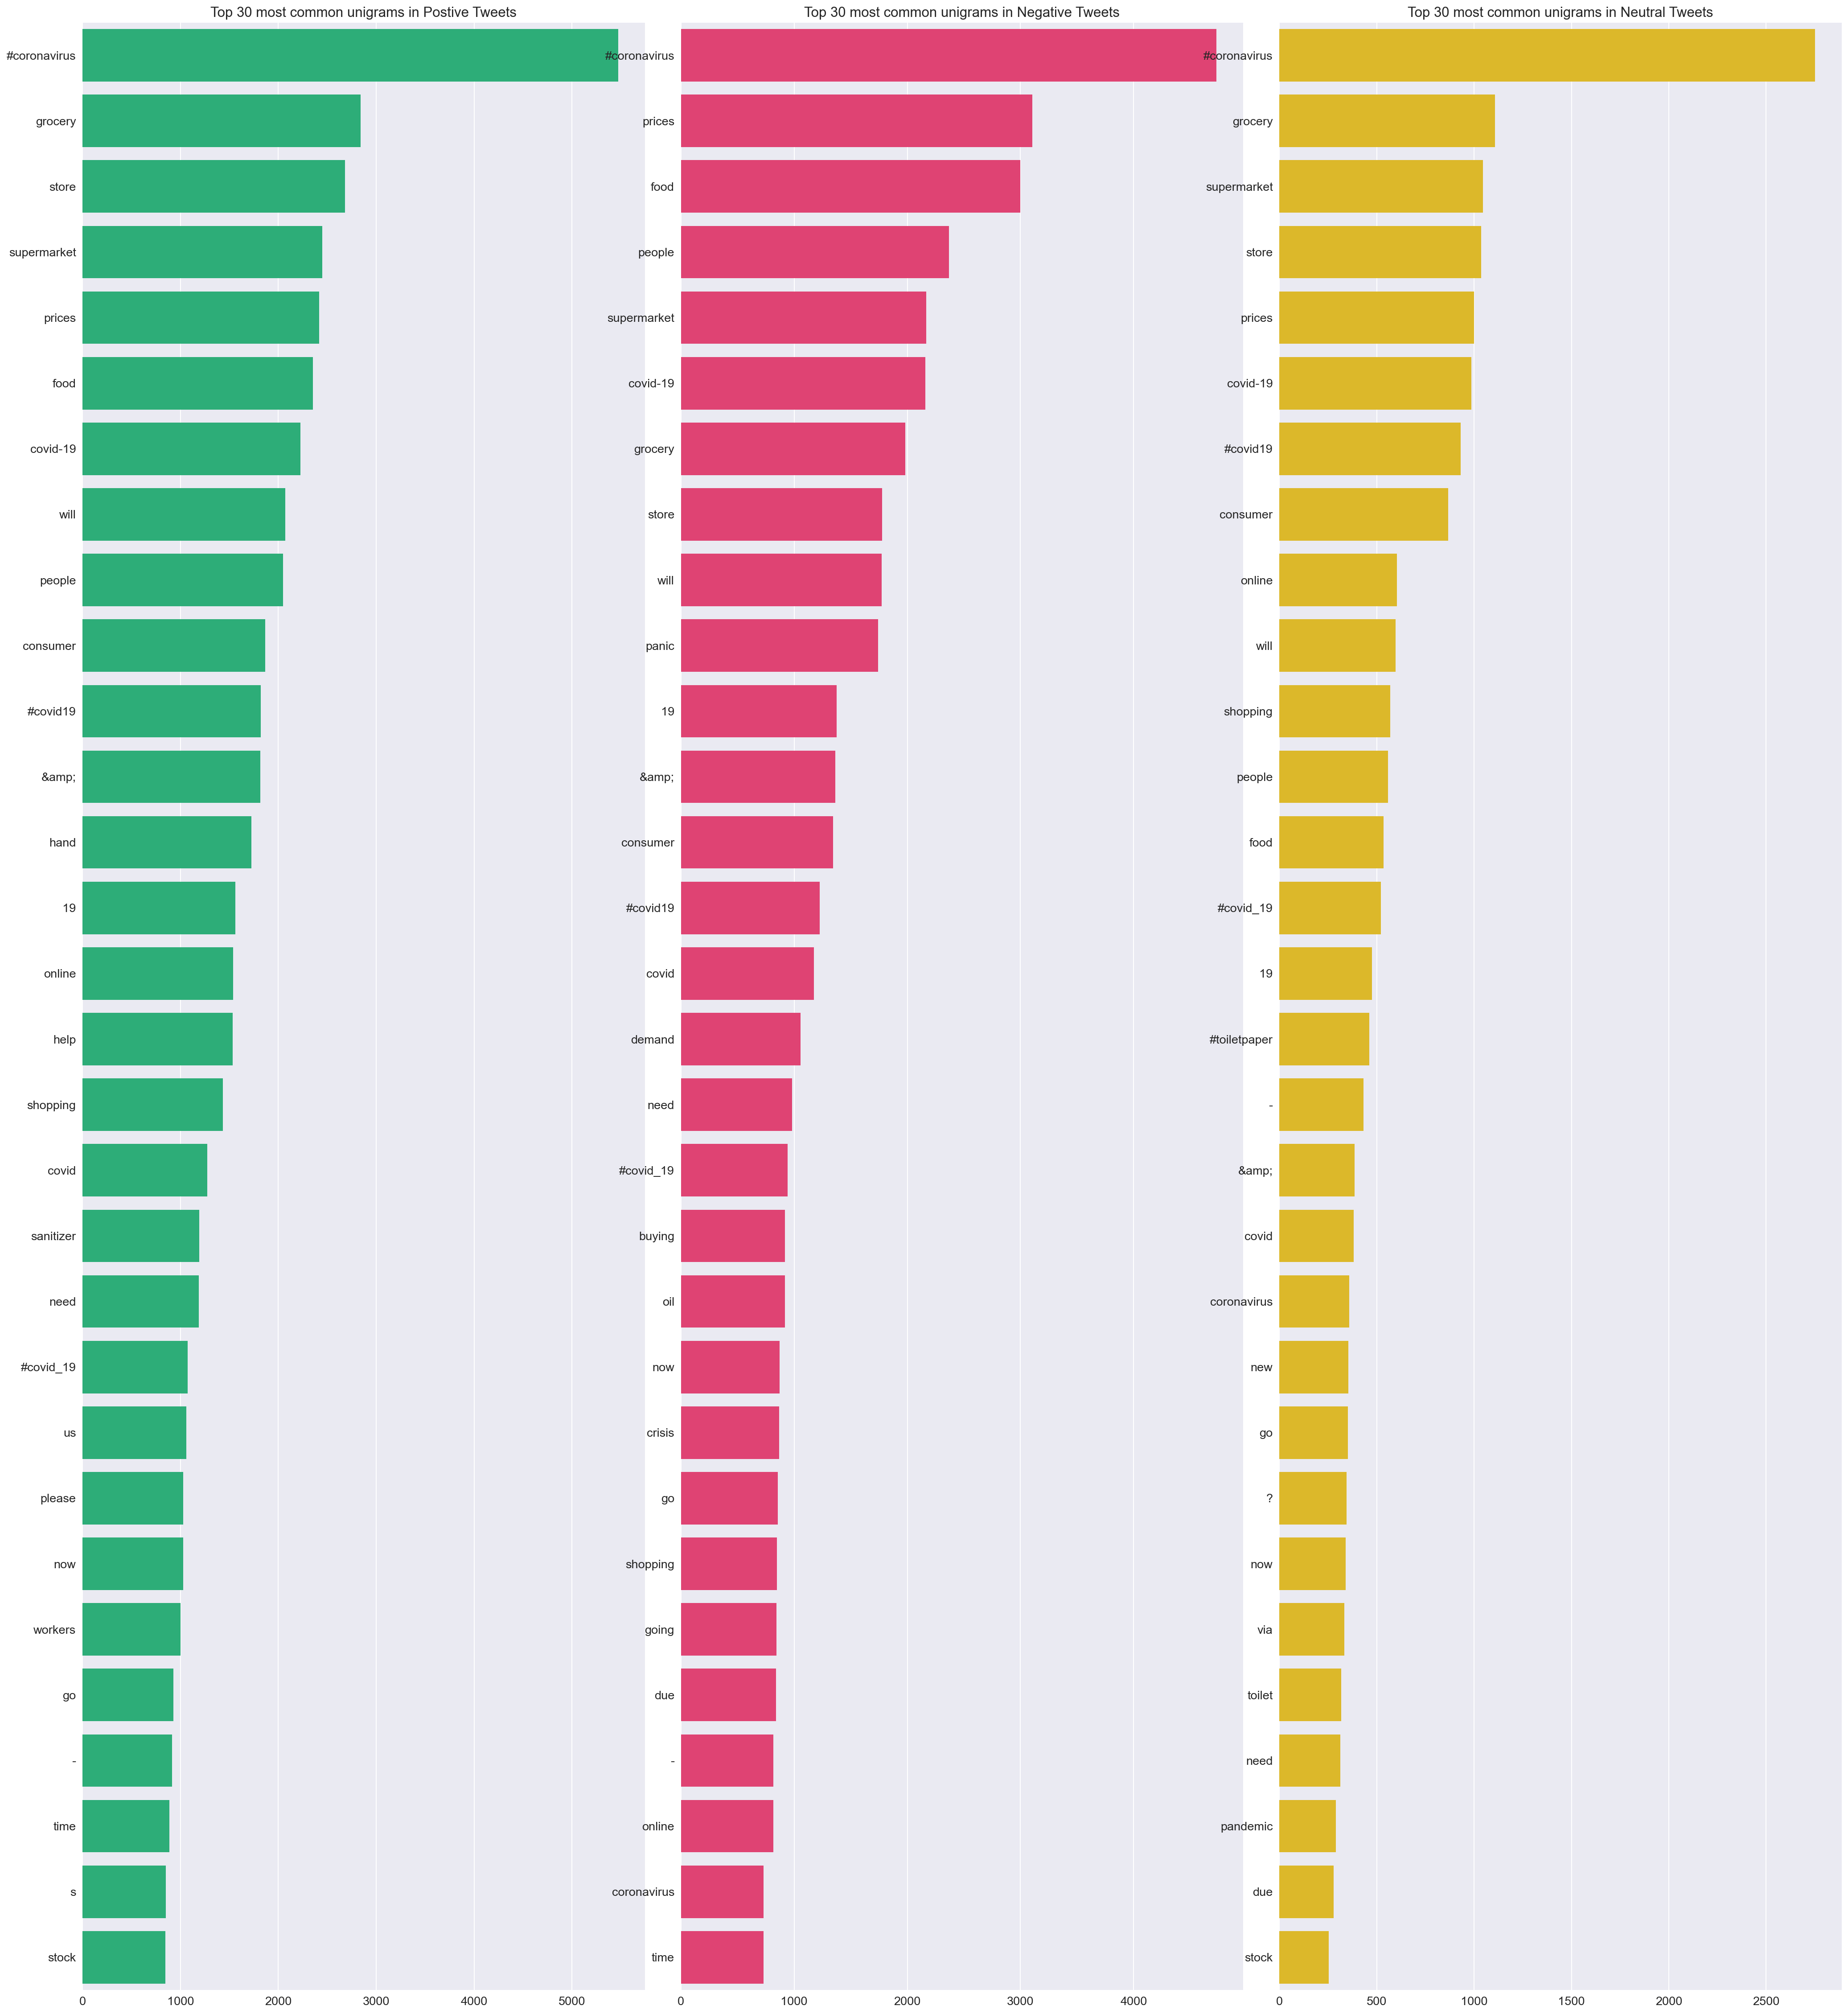

In [49]:
# Define functions
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 30
positive= train["sentiment"]== "positive"
negative= train["sentiment"]== "negative"
neutral= train["sentiment"]== "neutral"

positive_unigrams = defaultdict(int)
neutral_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)
# Unigrams
for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet):
        positive_unigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet):
        negative_unigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet):
        neutral_unigrams[word] += 1        
        
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_unigrams = pd.DataFrame(sorted(neutral_unigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=df_positive_unigrams[0].values[:N], x=df_positive_unigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_unigrams[0].values[:N], x=df_negative_unigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_unigrams[0].values[:N], x=df_neutral_unigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)
axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)
plt.show()